In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle

In [19]:
train_df = pd.read_csv(r"C:\Users\Admin\Downloads\Telegram Desktop\train.csv")
test_df = pd.read_csv(r"C:\Users\Admin\Downloads\Telegram Desktop\test.csv")

In [20]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [21]:
train_df.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [22]:
test_df.isnull().any()

id              False
comment_text    False
dtype: bool

In [23]:
cols_target = ["insult","toxic","severe_toxic","identity_hate","threat","obscene"]

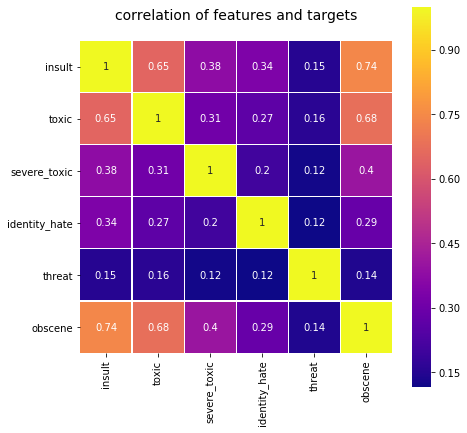

In [24]:
data = train_df[cols_target]


colormap = plt.cm.plasma
plt.figure(figsize = (7,7))
plt.title("correlation of features and targets",y = 1.05,size = 14)
sns.heatmap(data.astype(float).corr(),linewidths = 0.1,vmax = 1.0,square = True,cmap = colormap,linecolor = 'white',annot = True)

Cleaning the comment text using the function which converts the text to lower case and subsites the abbreviations with there complete words. Text from both train and test sets are cleaned. 

In [35]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's","what is",text)
    text = re.sub(r"\'s"," ",text)
    text = re.sub(r"\'ve","have",text)
    text = re.sub(r"can't","cannot",text)
    text = re.sub(r"n't","not",text)
    text = re.sub(r"i'm","i am",text)
    text = re.sub(r"\'re","are",text)
    text = re.sub(r"\'d","would",text)
    text = re.sub(r"\'ll'","will",text)
    text = re.sub(r"\'scuse","excuse",text)
    text = re.sub('\w',' ',text)
    text = re.sub('\s+',' ',text)
    return text


In [39]:
train_df['comment_text'] = train_df['comment_text'].map(lambda com : clean_text(com))
test_df['comment_text'] = test_df['comment_text'].map(lambda com : clean_text(com))

Count Vectorizer


Forming a Count Vectorizer (Converts a collection of text documents to a matrix of token counts) by combining the test and the train sets. 



In [38]:
train_text = train_df['comment_text']
test_text = train_df['comment_text']
all_text = pd.concat([train_text,test_text])

from sklearn.feature_extraction.text import CountVectorizer
word_vect = CountVectorizer(strip_accents = 'unicode',
                            analyzer = 'word',
                            token_pattern = r'\w{1,}',
                            stop_words = 'english',
                            ngram_range = (1,1))


Fitting the vectorizer, transforming the vocabulary learned into a document term matrix and saving the vectorizer in pickle or .pkl format.

In [43]:
word_vect.fit(all_text)

train_features  = word_vect.transform(train_text)
test_features  = word_vect.transform(test_text)

pickle.dump(word_vect.vocabulary_,open('word_feats.pkl','wb'))

Choose The Appropriate Model
Working with the Logistic Regression model

Building a multi-label classifier using Logistic Regression. For each target variable, the model is fitted and saved.



In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg= LogisticRegression(C=12.0)

In [49]:
submission_binary = pd.read_csv(r"C:\Users\Admin\Desktop\Telegram Desktop\sample_submission.csv")

In [51]:
mapper = {}
for label in cols_target:
    mapper[label]=logreg
    filename=str(label+'_model.sav')
    print(filename)
    print('...Processing {}'.format(label))
    y= train_df[label]
    mapper[label].fit(train_features,y)
    pickle.dump(mapper[label],open(filename,'wb'))
    y_pred_X = mapper[label].predict(train_features)
    print('Training accuracy is {}'.format(accuracy_score(y,y_pred_X)))
    test_y_prob = mapper[label].predict_proba(test_features)[:,1]
    submission_binary[label] = test_y_prob
    

insult_model.sav
...Processing insult
Training accuracy is 0.9506363938309592


ValueError: Length of values does not match length of index

In [53]:
submission_binary.to_csv('submission_binary.csv',index = False)